In [2]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
torch.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [4]:
dataset_dir = Path("../datasets")

In [6]:
class OneHot(object):
    """Creates one-hot vector given int"""
    def __init__(self, classes, dtype):
        self.classes = classes
        self.dtype = dtype

    def __call__(self, label):
        label = torch.tensor(label, dtype=torch.long)
        return F.one_hot(label, self.classes).to(self.dtype)

In [18]:
training_data = torchvision.datasets.MNIST(dataset_dir,
                        train=True,
                        download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                        ]),
                        target_transform=OneHot(10, dtype)
                        )

testing_data = torchvision.datasets.MNIST(dataset_dir,
                        train=False,
                        download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                        ]),
                        target_transform=OneHot(10, dtype)
                        )

training_loader = torch.utils.data.DataLoader(training_data,
                            batch_size=50,
                            shuffle=True)

training_metrics_loader = torch.utils.data.DataLoader(training_data,
                                batch_size=50,
                                shuffle=False)

testing_loader = torch.utils.data.DataLoader(testing_data,
                            batch_size=50,
                            shuffle=False)

testing_metrics_loader = torch.utils.data.DataLoader(testing_data,
                                batch_size=50,
                                shuffle=False)

In [144]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [145]:
network = Net().to(device)
optimizer = torch.optim.Adam(network.parameters())
loss_fn = nn.MSELoss()

In [146]:
num_batches = 0
for epoch in tqdm(range(10)):
    network.train()
    for sample, target in training_loader:
        optimizer.zero_grad()
        batch_loss = loss_fn(network(sample.to(device)), target.to(device))
        batch_loss.backward()
        optimizer.step()
        num_batches += 1
    network.eval()
    outof = 0
    testing_loss = 0
    testing_accuracy = 0
    with torch.no_grad():
        for sample, target in testing_metrics_loader:
            output = network(sample.to(device))
            _, pred = torch.max(output, 1)
            _, answer = torch.max(target.to(device), 1)
            testing_accuracy += (pred == answer).sum().item()
            testing_loss += loss_fn(output, target.to(device))
            outof += len(target)
    testing_loss = float(testing_loss / outof)
    testing_accuracy = testing_accuracy / outof
    print("Loss: {:.3E} | Acc: {:.2f}%".format(testing_loss, testing_accuracy*100))

Loss: 1.734E-04 | Acc: 95.11%
Loss: 1.086E-04 | Acc: 96.88%
Loss: 9.111E-05 | Acc: 97.24%
Loss: 7.807E-05 | Acc: 97.59%
Loss: 6.927E-05 | Acc: 97.86%
Loss: 6.365E-05 | Acc: 98.03%
Loss: 5.749E-05 | Acc: 98.24%
Loss: 5.362E-05 | Acc: 98.29%
Loss: 5.049E-05 | Acc: 98.59%
Loss: 4.739E-05 | Acc: 98.57%



# Okay now that the model is trained, let's do the feature visualization

In [162]:
target_creator = OneHot(10, dtype)

In [169]:
def visu_loss_fn(img, x, y, lbda=1.0):
    return torch.mean((x - y)**2) + lbda*torch.mean(img**2)

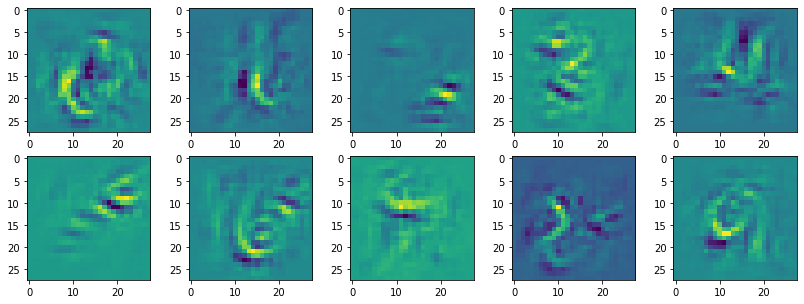

In [200]:
network.eval()

plt.figure(figsize=(14, 5))

for k in tqdm(range(10)):
    plt.subplot(2, 5, k+1)
    target = target_creator(k)
    img = torch.rand((1, 1, 28, 28), requires_grad=True)
    feature_optim = torch.optim.SGD([img], lr=1.0)
    for _ in range(500):
        feature_optim.zero_grad()
        batch_loss = visu_loss_fn(img.to(device), network(img.to(device)), target.to(device), lbda=5.0)
        batch_loss.backward()
        feature_optim.step()
    plt.imshow(img.detach()[0, 0])

# Let's optimize on the logits, not the sigmoid output

In [207]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)
    
    def forwardl(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [208]:
network = Net().to(device)
optimizer = torch.optim.Adam(network.parameters())
loss_fn = nn.MSELoss()

In [209]:
num_batches = 0
for epoch in tqdm(range(10)):
    network.train()
    for sample, target in training_loader:
        optimizer.zero_grad()
        batch_loss = loss_fn(network(sample.to(device)), target.to(device))
        batch_loss.backward()
        optimizer.step()
        num_batches += 1
    network.eval()
    outof = 0
    testing_loss = 0
    testing_accuracy = 0
    with torch.no_grad():
        for sample, target in testing_metrics_loader:
            output = network(sample.to(device))
            _, pred = torch.max(output, 1)
            _, answer = torch.max(target.to(device), 1)
            testing_accuracy += (pred == answer).sum().item()
            testing_loss += loss_fn(output, target.to(device))
            outof += len(target)
    testing_loss = float(testing_loss / outof)
    testing_accuracy = testing_accuracy / outof
    print("Loss: {:.3E} | Acc: {:.2f}%".format(testing_loss, testing_accuracy*100))

Loss: 1.979E-04 | Acc: 94.68%
Loss: 1.226E-04 | Acc: 96.39%
Loss: 9.748E-05 | Acc: 97.08%
Loss: 8.932E-05 | Acc: 97.31%
Loss: 7.725E-05 | Acc: 97.71%
Loss: 6.842E-05 | Acc: 98.04%
Loss: 6.218E-05 | Acc: 98.21%
Loss: 6.095E-05 | Acc: 98.20%
Loss: 6.130E-05 | Acc: 98.10%
Loss: 5.387E-05 | Acc: 98.43%



# And add total variation regularization

In [257]:
torch.rand((1, 1, 27, 28)).T.shape

torch.Size([28, 27, 1, 1])

In [264]:
target_creator = OneHot(10, dtype)
def visu_loss_fn(img, y, label, lbda=5.0, alpha=1.0, beta=1.0):
    target = target_creator(k).to(device)
    logit = torch.sum(y*target)
    dw = torch.square(img[:, :, :, :-1] - img[:, :, :, 1:])[0, 0]
    dh = torch.square(img[:, :, :-1, :] - img[:, :, 1:, :])[0, 0]
    TV = torch.mean(torch.pow((dw + dh.T), beta/2))
    return -logit + lbda*torch.mean(img**2) + alpha*TV

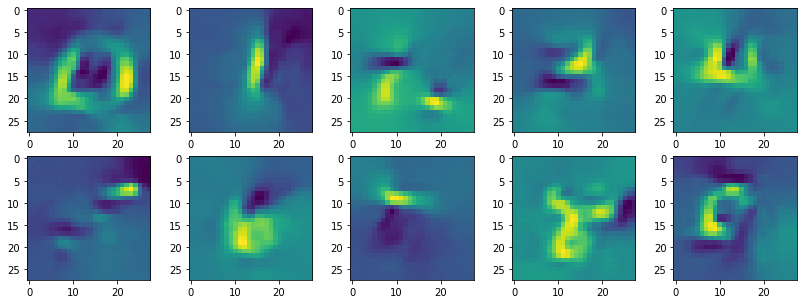

In [303]:
network.eval()

plt.figure(figsize=(14, 5))

for k in tqdm(range(10)):
    plt.subplot(2, 5, k+1)
    img = torch.rand((1, 1, 28, 28), requires_grad=True)
    feature_optim = torch.optim.Adam([img], lr=0.05)
    for _ in range(800):
        feature_optim.zero_grad()
        batch_loss = visu_loss_fn(img.to(device), network(img.to(device)), k, lbda=0.1, alpha=1, beta=1.5)
        batch_loss.backward()
        feature_optim.step()
    plt.imshow(img.detach()[0, 0])

In [294]:
del img

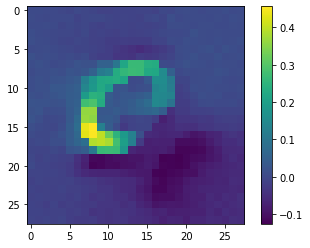

In [295]:
img = torch.rand((1, 1, 28, 28), requires_grad=True)
feature_optim = torch.optim.Adam([img], lr=0.05)
for _ in range(800):
    feature_optim.zero_grad()
    batch_loss = visu_loss_fn(img.to(device), network(img.to(device)), 7, lbda=1, alpha=2, beta=1.1)
    batch_loss.backward()
    feature_optim.step()
plt.imshow(img.detach()[0, 0])
plt.colorbar()

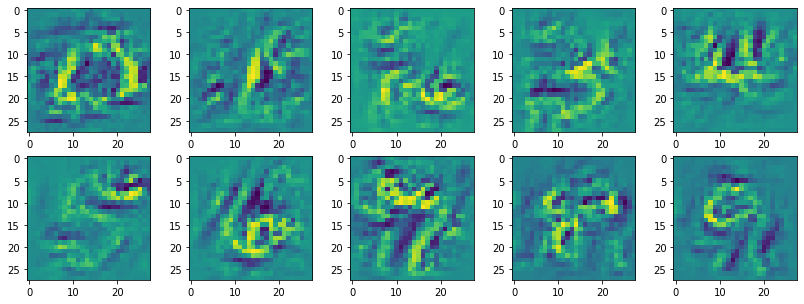

In [218]:
network.eval()

plt.figure(figsize=(14, 5))

for k in tqdm(range(10)):
    plt.subplot(2, 5, k+1)
    img = torch.rand((1, 1, 28, 28), requires_grad=True)
    feature_optim = torch.optim.Adam([img], lr=0.05)
    for _ in range(1000):
        feature_optim.zero_grad()
        batch_loss = visu_loss_fn(img.to(device), network.forwardl(img.to(device)), k, lbda=5.0)
        batch_loss.backward()
        feature_optim.step()
    plt.imshow(img.detach()[0, 0])

In [220]:
torch.norm?